<a href="https://colab.research.google.com/github/Darshil420/cabfarepredictor_linearregression/blob/main/linearregression_cabfareprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cab fare predictor using Linear(ridge) regression

importing files and libraries

In [ ]:
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
fileid = "1-5wBAWfLrFHYBryEeJ0Rw0FK8w6W115O"
gdown.download(f"https://drive.google.com/uc?id={fileid}", "taxi_trip_pricing.csv", quiet=False)
df = pd.read_csv("taxi_trip_pricing.csv")
print(type(df))

Downloading...
From: https://drive.google.com/uc?id=1-5wBAWfLrFHYBryEeJ0Rw0FK8w6W115O
To: /content/taxi_trip_pricing.csv
100%|██████████| 1.51M/1.51M [00:00<00:00, 154MB/s]

<class 'pandas.core.frame.DataFrame'>


data cleaning and preprocessing


   Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count  \
0         38.148263   Afternoon     Weekend         1.005003   
1         49.564947   Afternoon     Weekday         2.003430   
2         43.312913   Afternoon     Weekend         3.021207   
3        104.053116         NaN     Weekday         1.008493   
4          8.370372     Morning     Weekday         1.983303   

  Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  \
0                Low   Clear   2.990531     0.642415         0.410424   
1                Low   Clear   2.363245     0.858639         0.398510   
2                Low   Clear   2.302173     0.728171         0.420948   
3                Low    Rain   3.216353     1.126401         0.451314   
4               High    Rain   4.790937     1.791886         0.458452   

   Trip_Duration_Minutes  Trip_Price  
0              31.335285   40.853603  
1              47.552324   63.730307  
2              53.851719   56.370793  
3              89.60

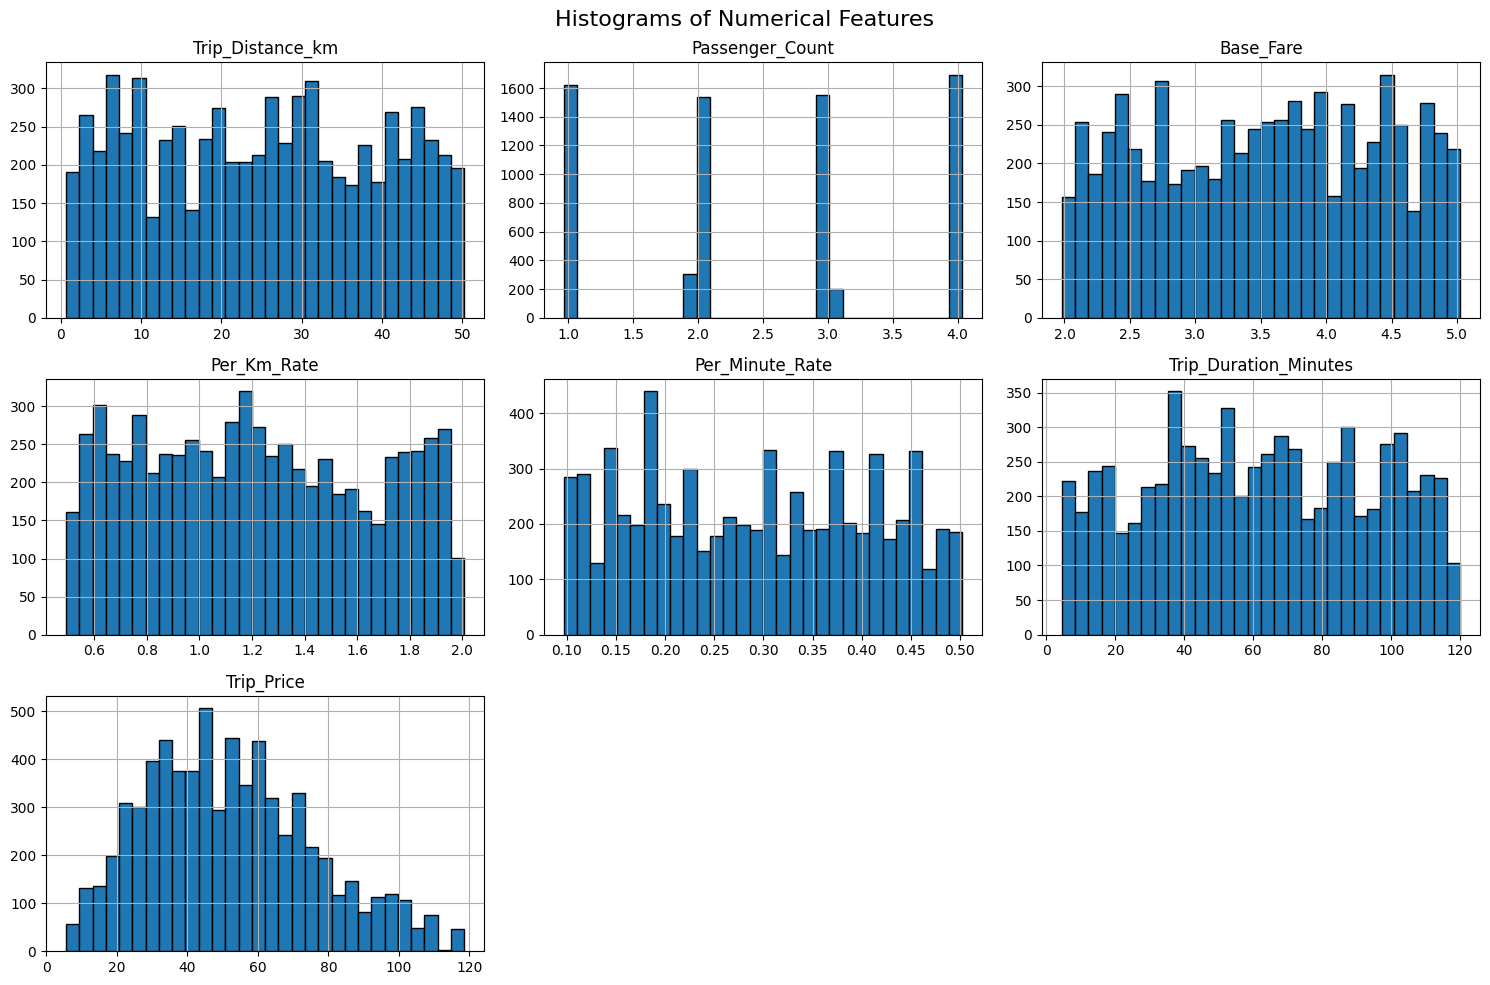

In [ ]:
print(df.head())
print(df.info())
print(df.describe())
missing=df.isnull().sum()
print(missing)

#data cleaning
df.drop_duplicates(subset=None,keep='first',inplace=True)

#outlier removal
for col in df.select_dtypes(include='number').columns:
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3 - Q1

    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR

    df = df[(df[col]>=lower_bound)&(df[col]<=upper_bound)]

#categorical datacleaning
for col in df.select_dtypes(include='object').columns:
    modeval=df[col].mode(dropna=True)
    df[col]=df[col].fillna(modeval[0])

#numerical datacleaning
for col in df.select_dtypes(include='number').columns:
    skewval=df[col].skew()
    if -0.5<skewval<0.5:
        df[col]=df[col].fillna(df[col].mean())
        method="mean"
    else:
        df[col]=df[col].fillna(df[col].median())
        method="median"

    print(f"{col}: skew={skewval:.3f},method={method}")

#outliers check
numerical_cols = df.select_dtypes(include=['int64','float64']).columns
# histograms
df[numerical_cols].hist(figsize=(15, 10), bins=30, edgecolor='black')
plt.suptitle('Histograms of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()


data encoding

/tmp/ipython-input-960526688.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Day_of_Week']=df['Day_of_Week'].replace({"Weekday":1,"Weekend":0})
/tmp/ipython-input-960526688.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Traffic_Conditions"]=df["Traffic_Conditions"].replace({"Low":0,"Medium":1,"High":2})


   Trip_Distance_km  Day_of_Week  Passenger_Count  Traffic_Conditions  \
0         38.148263            0         1.005003                   0   
1         49.564947            1         2.003430                   0   
2         43.312913            0         3.021207                   0   
4          8.370372            1         1.983303                   2   
6         49.113848            1         3.011177                   2   

   Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  Trip_Price  \
0   2.990531     0.642415         0.410424              31.335285   40.853603   
1   2.363245     0.858639         0.398510              47.552324   63.730307   
2   2.302173     0.728171         0.420948              53.851719   56.370793   
4   4.790937     1.791886         0.458452              71.098842   52.639902   
6   3.575789     1.213779         0.221059              27.655559   69.075482   

   Time_of_Day_Evening  Time_of_Day_Morning  Time_of_Day_Night  Weather_Ra

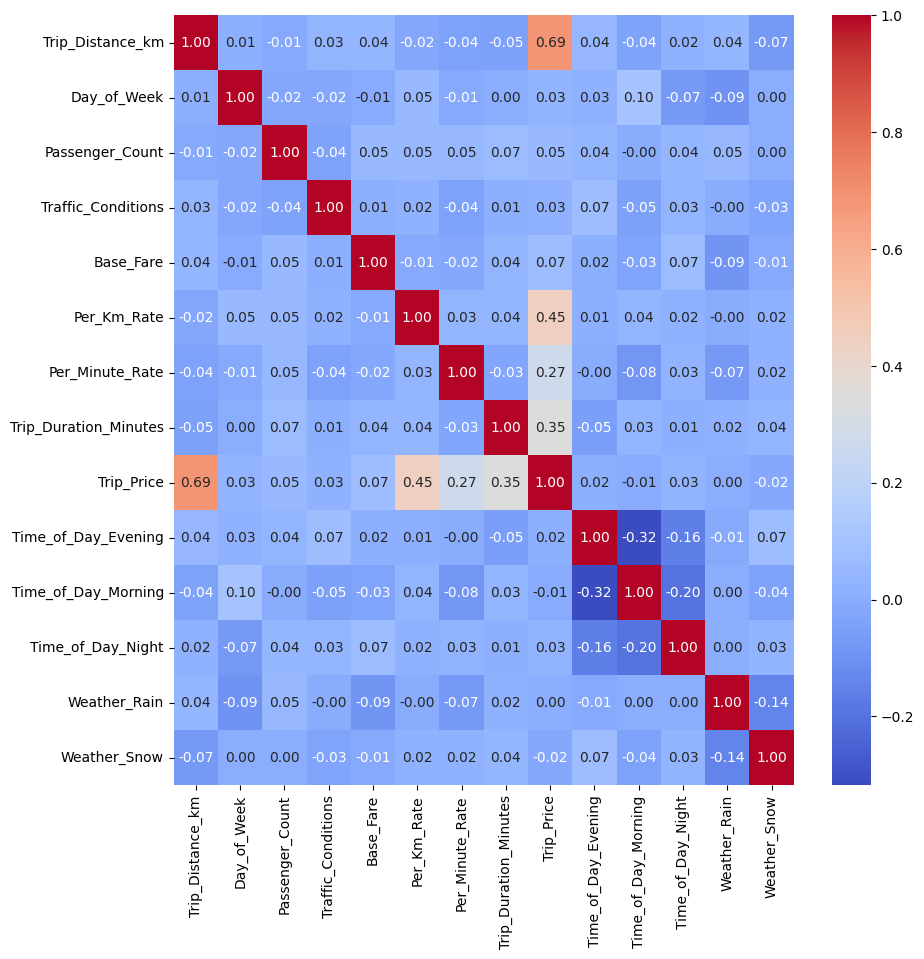

In [ ]:
#encoding(hot,binary,ordinal)
df=pd.get_dummies(df,columns=['Time_of_Day','Weather'],drop_first=True)
df['Day_of_Week']=df['Day_of_Week'].replace({"Weekday":1,"Weekend":0})
df["Traffic_Conditions"]=df["Traffic_Conditions"].replace({"Low":0,"Medium":1,"High":2})
print(df.head())

#correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt=".2f")
plt.show()

define features and target values


In [ ]:
X=df.drop("Trip_Price",axis=1)   # Features
Y=df["Trip_Price"]                # Target
print(X)
print(Y)

      Trip_Distance_km  Day_of_Week  Passenger_Count  Traffic_Conditions  \
0            38.148263            0         1.005003                   0   
1            49.564947            1         2.003430                   0   
2            43.312913            0         3.021207                   0   
4             8.370372            1         1.983303                   2   
6            49.113848            1         3.011177                   2   
...                ...          ...              ...                 ...   
9995         34.982223            1         3.018814                   0   
9996         31.456910            1         3.990910                   2   
9997         46.351479            1         3.979336                   0   
9998         39.659527            1         2.997674                   1   
9999         15.321312            0         3.027822                   1   

      Base_Fare  Per_Km_Rate  Per_Minute_Rate  Trip_Duration_Minutes  \
0      2.990531

splitting and scaling(z-score) the data

In [ ]:
x_train,x_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
scaler=StandardScaler()
X_train=scaler.fit_transform(x_train)
X_test=scaler.transform(x_test)

creating and training the model

In [ ]:
model = LinearRegression()
model.fit(X_train,Y_train)

LinearRegression()

model predictions and evaluation

[17.19812548 -0.08163408 -0.04846451  0.0359868   1.03155547 10.37282081
  7.27310644  8.86196605  0.09048143  0.51012015 -0.14432801 -0.20425695
  0.16124837]
51.826897719386416


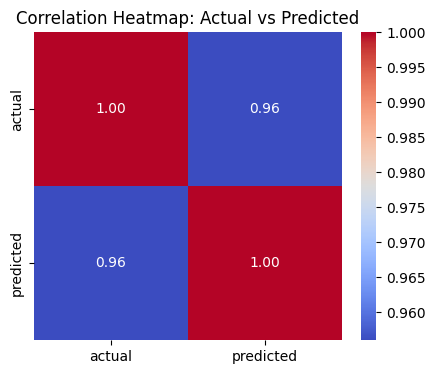

mean sbsolute rrror: 5.530417896392891
mean dquared rrror: 50.72235081625074
root mean squared error: 7.121962567737262
R² Score: 0.9137722867688212


In [ ]:
#prediction
Y_pred=model.predict(X_test)
print(model.coef_)
print(model.intercept_)

#heatmap btw actual vs predicted values
df_corr=pd.DataFrame({
    "actual":Y_test,
    "predicted":Y_pred
})

plt.figure(figsize=(5,4))
sns.heatmap(df_corr.corr(),annot=True,cmap="coolwarm",fmt=".2f",square=True)
plt.title("Correlation Heatmap: Actual vs Predicted")
plt.show()

#evaluation metrices
mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
rmse=np.sqrt(mse)
r2=r2_score(Y_test,Y_pred)

print("mean sbsolute rrror:",mae)
print("mean dquared rrror:",mse)
print("root mean squared error:",rmse)
print("R² Score:",r2)


using ridge regularization to improve accuracy (multicollinearity exists)

mean absolute error:  5.530496744189608
mean squared error:  50.724559112071475
R2 score:  0.9137685326782536


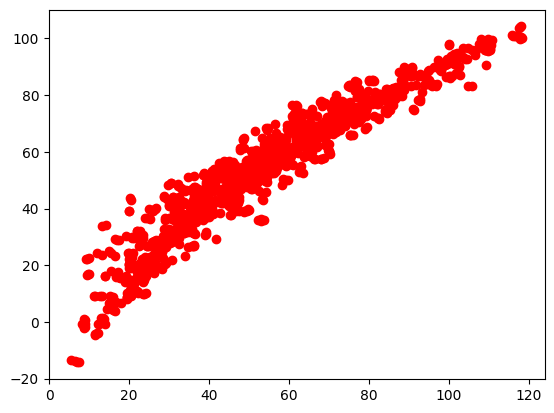

In [ ]:
ridge=Ridge()
ridge.fit(X_train,Y_train)
Y_pred=ridge.predict(X_test)

mae=mean_absolute_error(Y_test,Y_pred)
mse=mean_squared_error(Y_test,Y_pred)
score=r2_score(Y_test,Y_pred)

print("mean absolute error: ",mae)
print("mean squared error: ",mse)
print("R2 score: ",score)

plt.scatter(Y_test,Y_pred,color="red")
plt.show()

In [ ]:
import pickle

# Save the trained Ridge model to a pickle file
filename = 'model.pkl'
pickle.dump(ridge, open(filename, 'wb'))

print(f"Model saved to {filename}")

Model saved to model.pkl
